# EDA
Here I will explore relationships between the different features in my data.

**imports**

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data separation/transformation
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

# system manipulation
import itertools
import os
import sys
sys.path.append("./util_")
import prepare_
import explore_

# other
import env
import warnings
warnings.filterwarnings("ignore")

# set the random seed
np.random.seed(95)


# set a default them for all my visuals
sns.set_theme(style="whitegrid")

**get data**
 I am using training data. Data was split and saved into a separate file from preparation stage.


In [2]:
# get the training data not encoded
train = pd.read_csv("00_project_data/01_original_clean_no_dummies_train.csv", index_col=0)
train = train.reset_index(drop=True)

In [3]:
train.head()

,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,fatality,borough_good
0,0,0,0,0,0,0,0,0,vehicle failure,uncertain unspecified,uncertain unspecified,uncertain unspecified,uncertain unspecified,van,car,unknown,unknown,unknown,0,staten island
1,0,0,0,0,0,0,0,0,unsafe driving,uncertain unspecified,uncertain unspecified,uncertain unspecified,uncertain unspecified,truck,car,unknown,unknown,unknown,0,unknown
2,0,0,0,0,0,0,0,0,driver,uncertain unspecified,uncertain unspecified,uncertain unspecified,uncertain unspecified,car,car,unknown,unknown,unknown,0,unknown
3,1,0,0,0,1,0,0,0,visibility,driver experience,uncertain unspecified,uncertain unspecified,uncertain unspecified,van,other,unknown,unknown,unknown,0,brooklyn
4,0,0,0,0,0,0,0,0,unsafe driving,uncertain unspecified,uncertain unspecified,uncertain unspecified,uncertain unspecified,truck,van,unknown,unknown,unknown,0,brooklyn


### What is the distribution of the target variable?

- Calculate the frequency or proportion of the targe instances in the 'target' column.

In [4]:
# look at the fatality numbers
print(train.fatality.value_counts())
print(train.fatality.value_counts(normalize=True))

# 0.001382 of all new york city collisions end in fatalities (1663 accidents)

0    756098
1       955
Name: fatality, dtype: int64
0    0.998739
1    0.001261
Name: fatality, dtype: float64


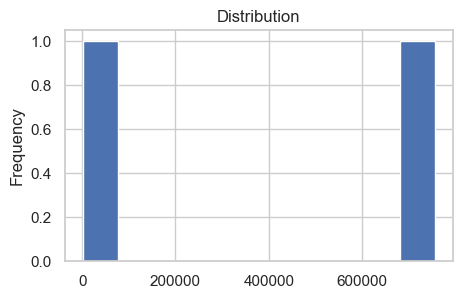

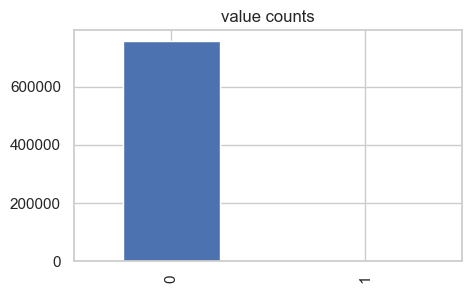

In [5]:
# visualize the distribution
train.fatality.value_counts().plot(kind="hist", figsize=(5,3))
plt.title("Distribution")
plt.show()

train.fatality.value_counts().plot(kind="bar", figsize=(5,3))
plt.title("value counts")
plt.show()

### What is the distribution of each feature in the dataset?

- Plot histograms for numerical variables and count plots for categorical variables to visualize their distributions.

**Numeric**

In [6]:
# select numeric data type columns
numerics = train.select_dtypes("number")
numerics.columns

Index(['number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed', 'fatality'],
      dtype='object')

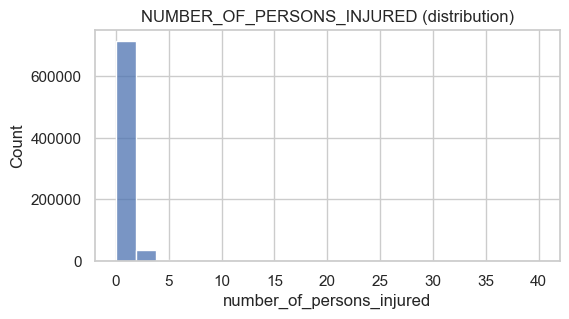

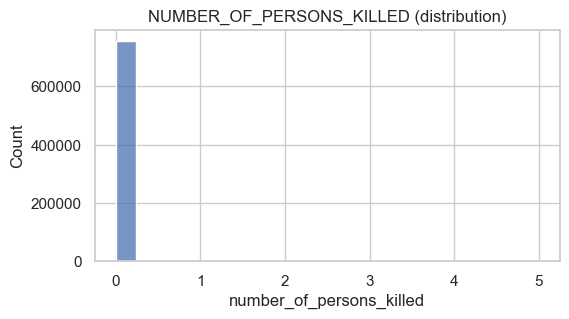

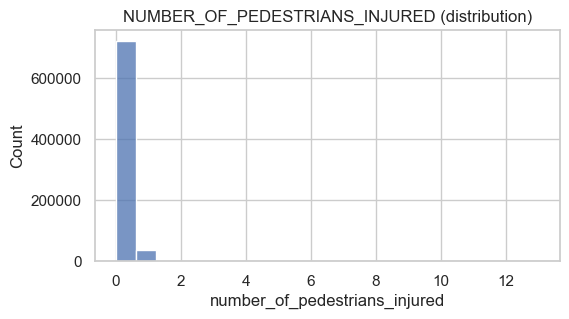

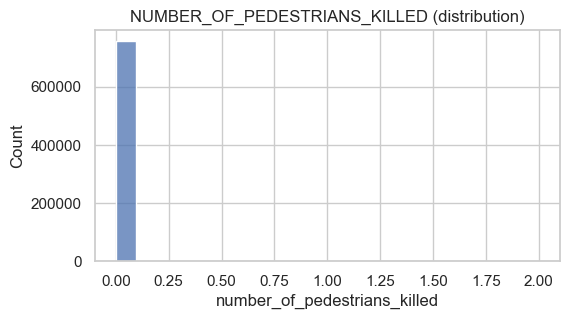

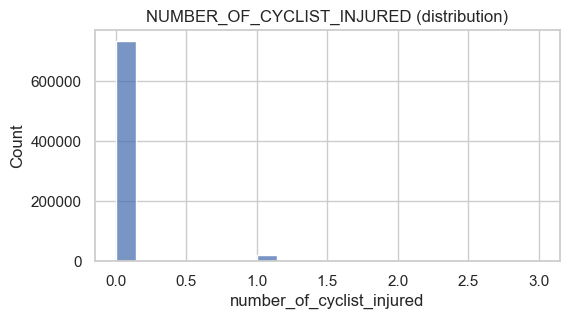

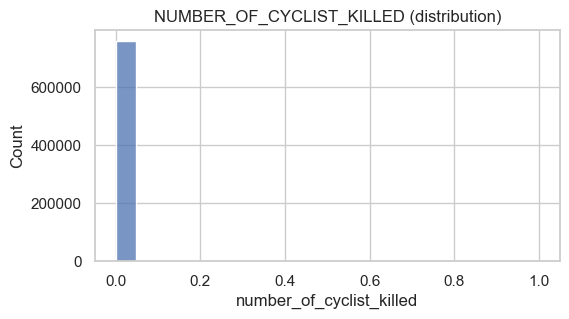

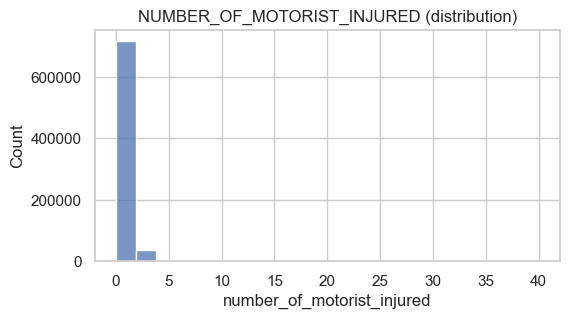

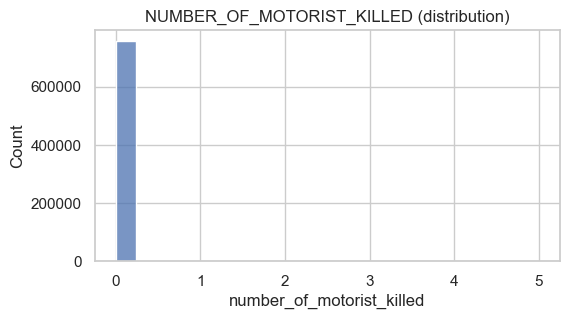

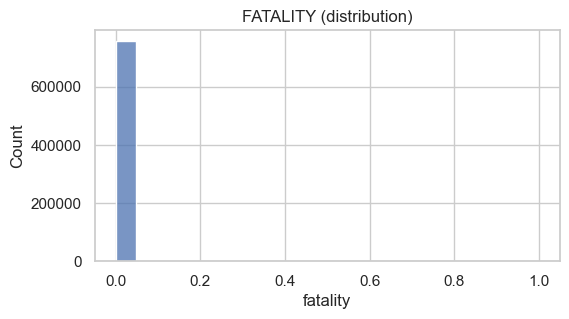

In [7]:
for col in numerics.columns:
    plt.figure(figsize=(6,3))
    sns.histplot(train[col])
    plt.title(f"{col.upper()} (distribution)")
    plt.show()

**Categorical**

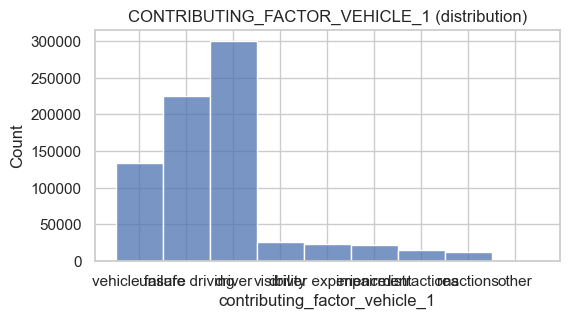

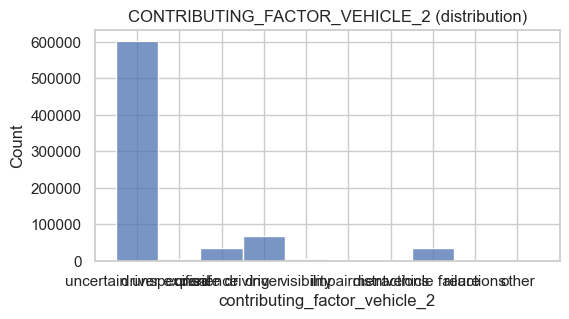

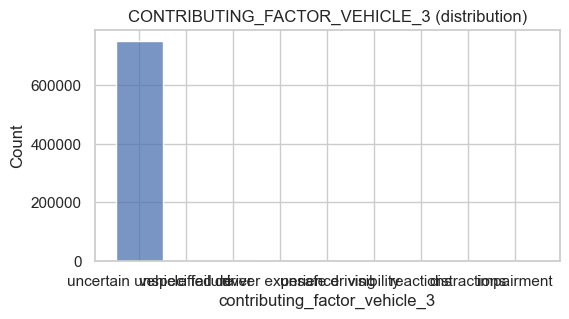

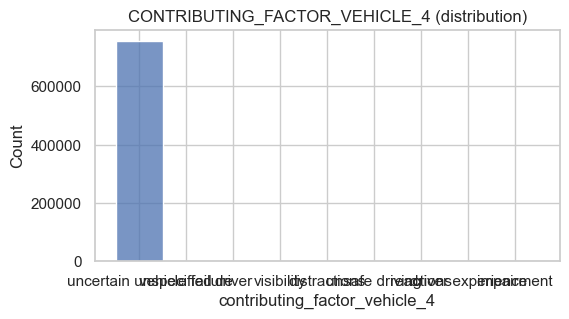

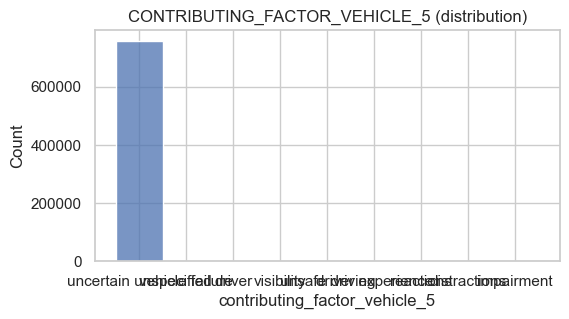

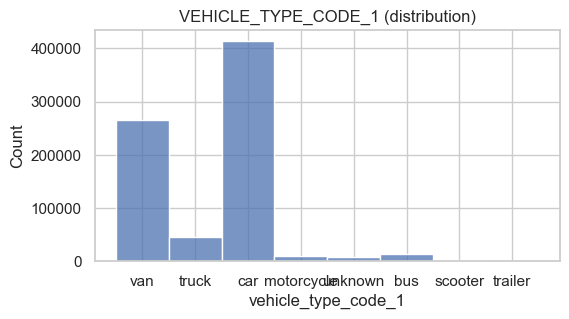

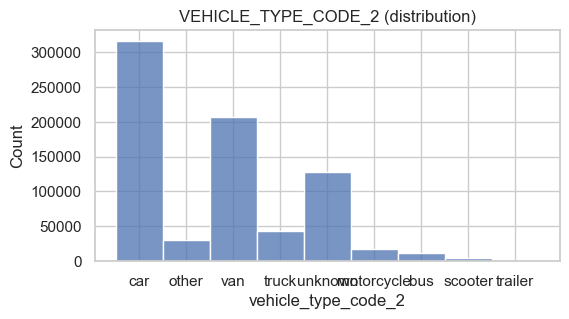

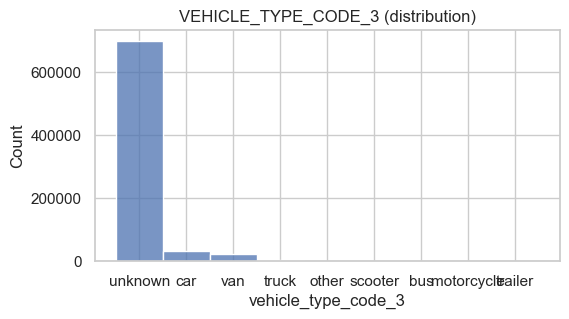

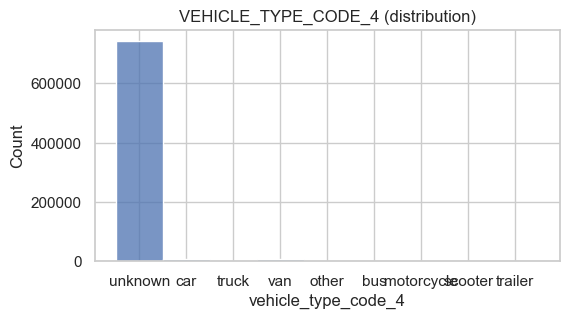

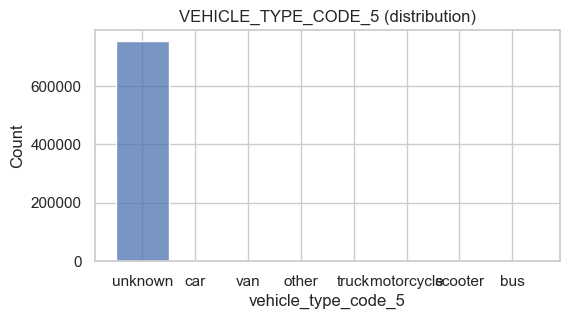

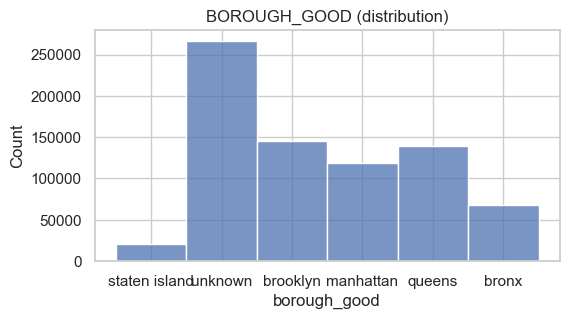

In [10]:
# select numeric data type columns
categorical_data = train.select_dtypes("object")

for col in categorical_data.columns:
    plt.figure(figsize=(6,3))
    sns.histplot(train[col])
    plt.title(f"{col.upper()} (distribution)")
    plt.show()

### What is the relationship between each feature with each other?

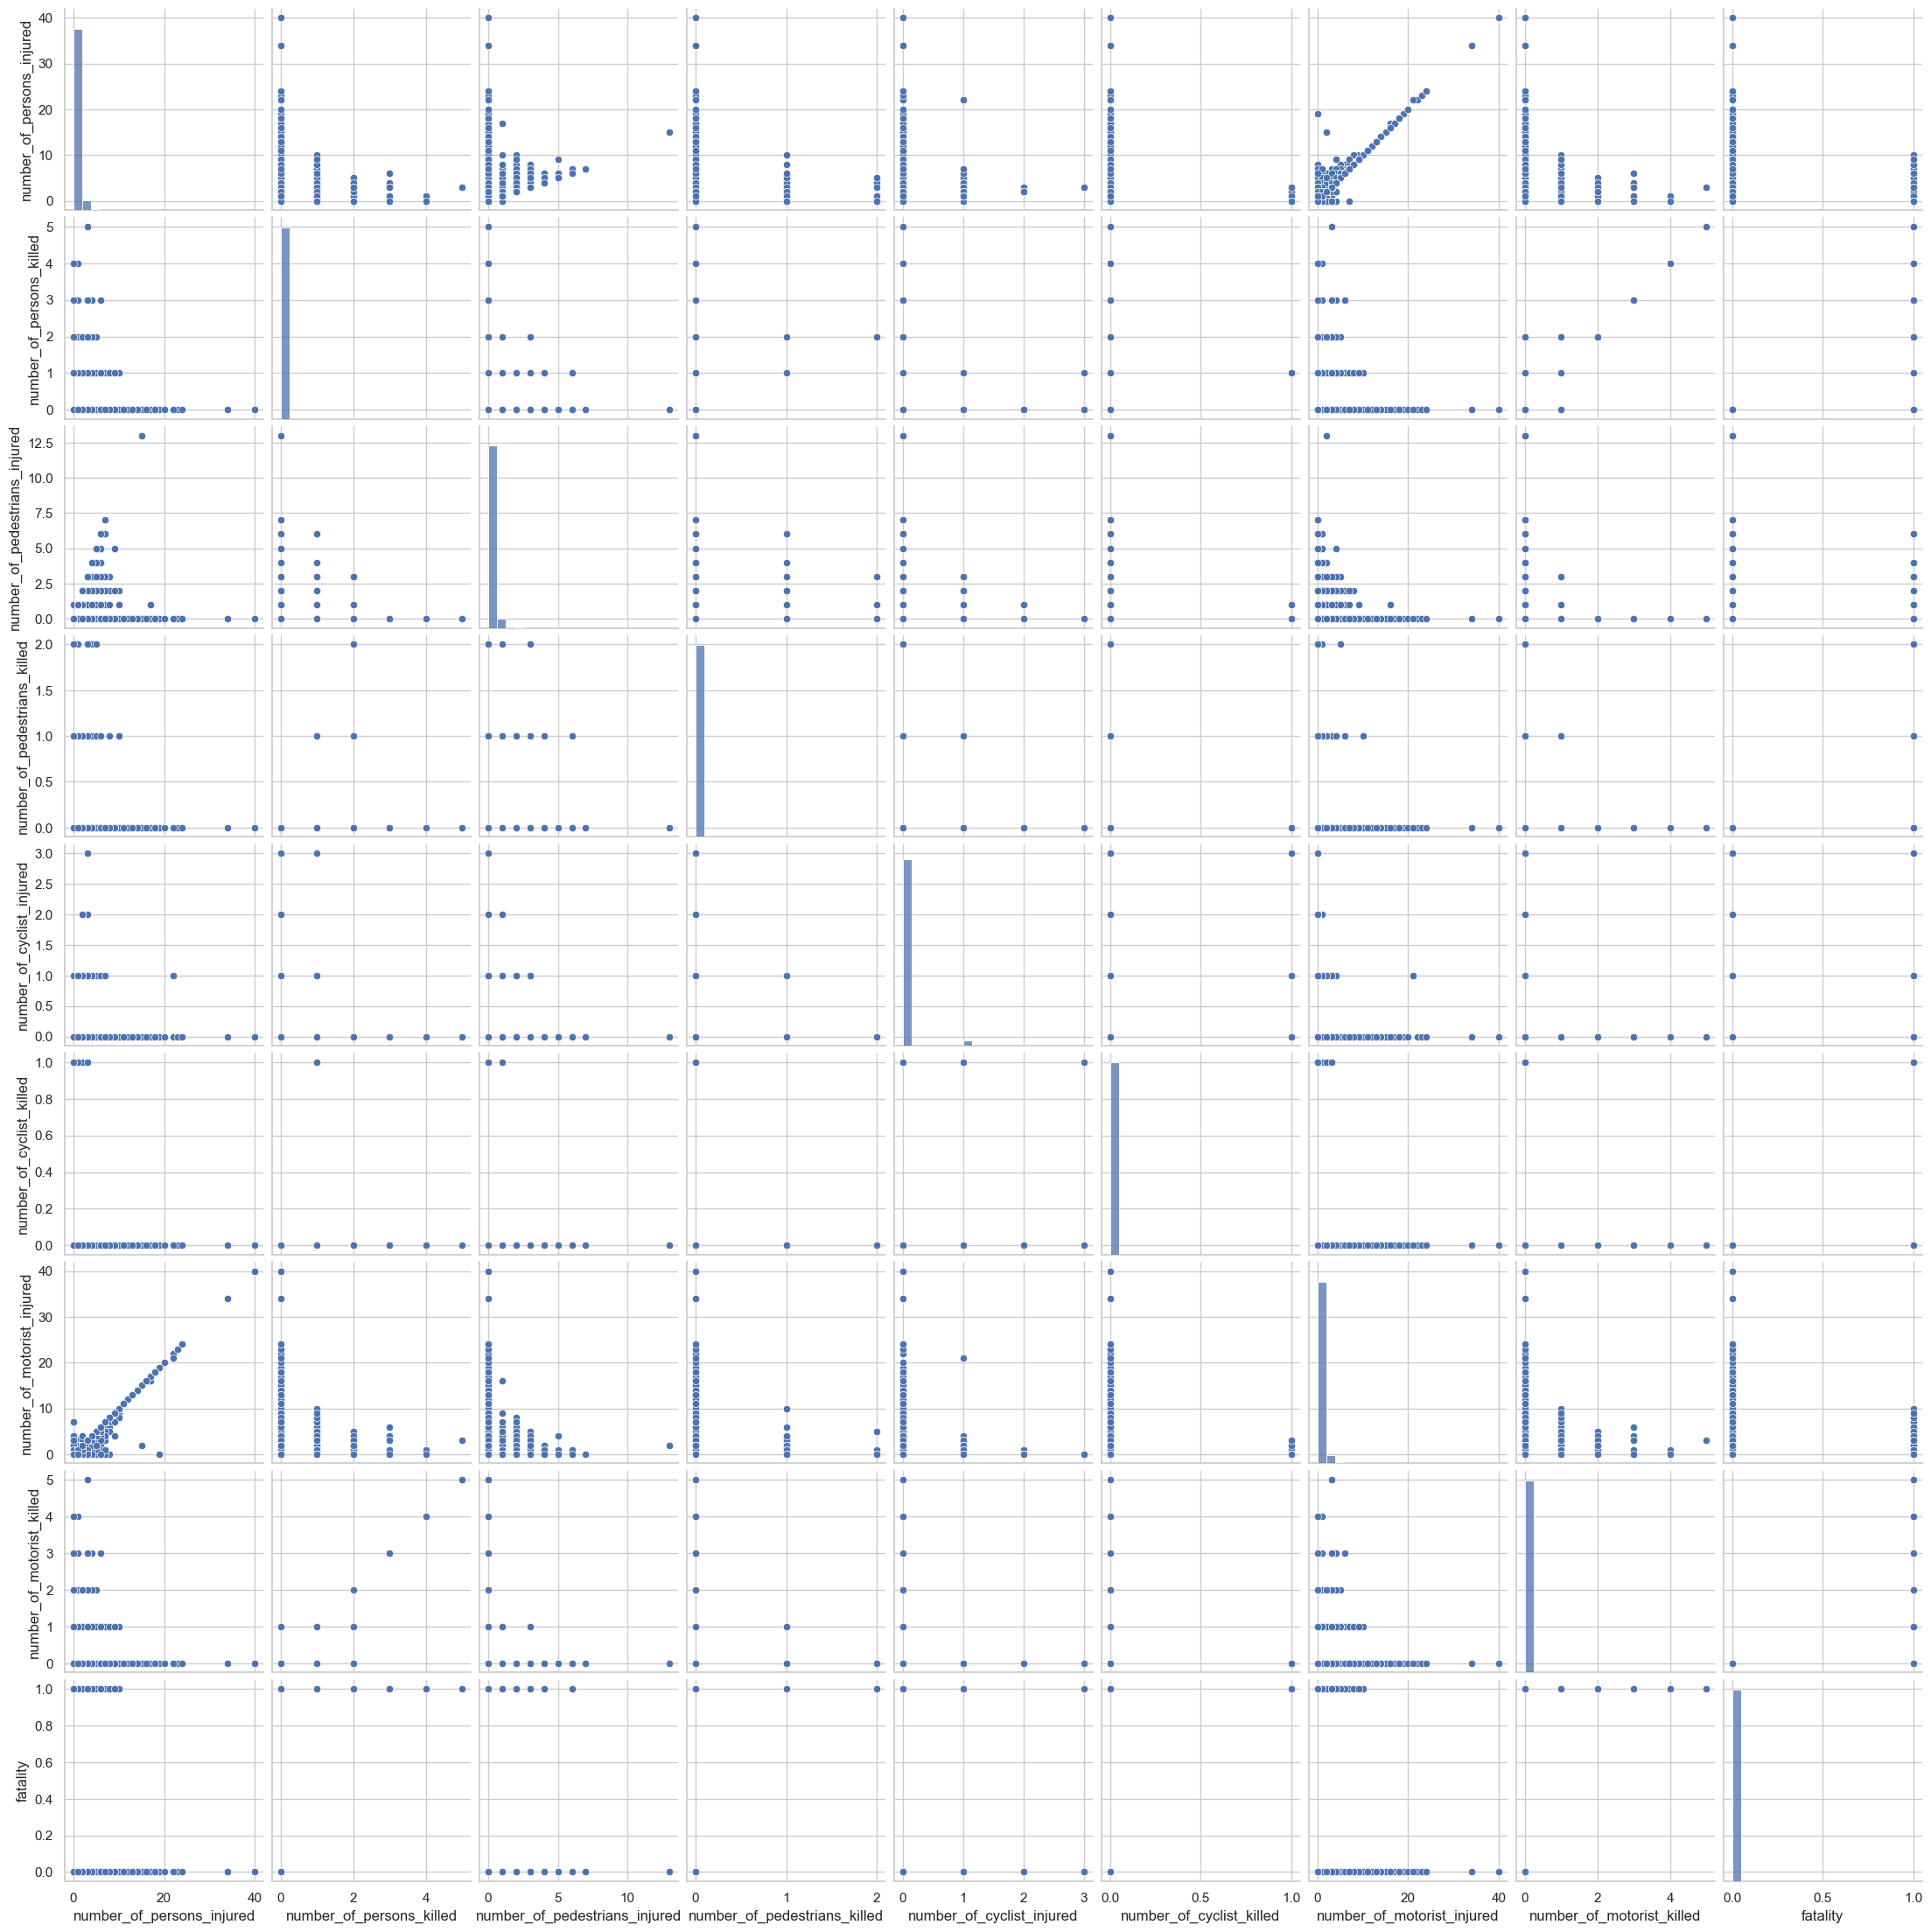

In [14]:
sns.pairplot(train)

- Is there a relationship between the number of personel ingered and the number of motorist injured?
- Is there a relationship between the number of pedestrians ingered and the number of motorist injured?
- Is there a relationship between the number of pedestrians ingered and the number of personel injured?

- Is there a relationship between the number of personel killed and the number of motorist killed?
- Is there a relationship between the number of motorist injured and the number of motorist killed?

### What is the relationship between each feature with the target

### Are there any significant differences in the distribution of features between the targets unique groups?

- look at how the diffent target groups differ in means and dirstributons.

### Are there any strong correlations between features?

- Create a correlation matrix or heatmap to examine the correlations between numerical features.

In [15]:
sns.pairplot(train, hue="fatality")

Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x1245eadd0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.10/weakref.py", line 54, in _cb
KeyboardInterrupt: 

KeyboardInterrupt



Error in callback <function flush_figures at 0x120a89a20> (for post_execute):



KeyboardInterrupt



### Visual Take Aways

**Temporal Analysis**

Are there any patterns or trends in the number of accidents and fatalities over time (e.g., by month, day of the week, or hour of the day)?

    - 
    
Is there any seasonality in the occurrence of accidents and fatalities?

    - 
    
**Spatial Analysis**

Are there specific boroughs or areas with a higher frequency of accidents or fatalities?

    - 
    
Do certain locations or intersections have a higher occurrence of accidents resulting in fatalities?

    - 

**Multivariate Analysis**

Can you identify interactions or combined effects of multiple variables on fatality?
Example, you can explore how the number of persons injured varies with different contributing factors and vehicle types.

    - 
    
What are the summary statistics (mean, median, standard deviation, etc.) for the numerical variables, and how do they differ for fatality vs. non-fatality instances?

    - 

What are the most common categories and their frequencies for categorical variables?

    - 